# Implementation of AlexNet

Lets import the necessary modules

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL

Looks good ! lets start by building the AlexNet model. The architecture of the actual model is something like this but deployed and trained on two sperate GPUS

<img src="https://miro.medium.com/max/1400/1*fn1hesVtSJzTKyxBfl9nxg.jpeg" height = "200" width = "500">
<img src="images\architecture.png">

First Layer: The input for AlexNet is a 227x227x3 (32x32x3 for this dataset) RGB image which passes through the first convolutional layer with 96 feature maps or filters having size 11×11 and a stride of 4. The image dimensions changes to 55x55x96. Then the AlexNet applies maximum pooling layer or sub-sampling layer with a filter size 3×3 and a stride of two. The resulting image dimensions will be reduced to 27x27x96

Second Layer: Next, there is a second convolutional layer with 256 feature maps having size 5×5 and a stride of 1. Then there is again a maximum pooling layer with filter size 3×3 and a stride of 2. This layer is same as the second layer except it has 256 feature maps so the output will be reduced to 13x13x256.

Third, Fourth and Fifth Layers: The third, fourth and fifth layers are convolutional layers with filter size 3×3 and a stride of one. The first two used 384 feature maps where the third used 256 filters. The three convolutional layers are followed by a maximum pooling layer with filter size 3×3, a stride of 2 and have 256 feature maps.

Sixth Layer: The convolutional layer output is flatten through a fully connected layer with 9216 feature maps each of size 1×1.

Seventh and Eighth Layers: Next is again two fully connected layers with 4096 units.

Output Layer: Finally, there is a softmax output layer ŷ with 1000 possible values.

In [2]:
# lets import the tensorflow modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [3]:
# AlexNet model
class AlexNet(Sequential):
  def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
    
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))

    self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None)) 

    self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))

    self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))

    self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))

    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))

    self.add(Flatten())
    self.add(Dense(4096, activation= 'relu'))
    self.add(Dense(4096, activation= 'relu'))
    self.add(Dense(1000, activation= 'relu'))
    self.add(Dense(num_classes, activation= 'softmax'))

    self.compile(optimizer= tf.keras.optimizers.Adam(0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [4]:
num_classes = 2
model = AlexNet((227, 227, 3), num_classes)

In [5]:
model.summary()

Model: "alex_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 256)       884

Lets define some training parameters

In [6]:
EPOCHS = 20
BATCH_SIZE = 32
image_height = 227
image_width = 227
train_dir = "data/training_set"
valid_dir = "data/test_set"
model_dir = "alex_net.h5"

### OKAYY!! So lets prepare the data, I will use a simple Dogs v Cats Classifier here
#### The source of the data : <https://www.kaggle.com/tongpython/cat-and-dog>

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
train_datagen = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=10,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  shear_range=0.1,
                  zoom_range=0.1)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(image_height, image_width),
                                                    color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="binary")

valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=(image_height, image_width),
                                                    color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                    seed=7,
                                                    shuffle=True,
                                                    class_mode="binary"
                                                    )
train_num = train_generator.samples
valid_num = valid_generator.samples

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [9]:
#Callbacks

checkpoint = tf.keras.callbacks.ModelCheckpoint('alexnet.h5', monitor='val_loss', verbose=0, save_best_only=True,
                                                save_weights_only=False, mode='auto', save_freq='epoch')

early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1, mode='auto')

callback_list = [early, checkpoint]

In [10]:
# start training
hist = model.fit(train_generator,
                    epochs=EPOCHS,
                    steps_per_epoch=train_num // BATCH_SIZE,
                    validation_data=valid_generator,
                    validation_steps=valid_num // BATCH_SIZE,
                    callbacks=callback_list,
                    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 250 steps, validate for 63 steps
Epoch 1/20
250/250 [==============================] - 117s 469ms/step - loss: 2.9524 - accuracy: 0.2998 - val_loss: 0.6945 - val_accuracy: 0.0000e+00
Epoch 2/20
250/250 [==============================] - 106s 425ms/step - loss: 0.6954 - accuracy: 0.0401 - val_loss: 0.6945 - val_accuracy: 0.0000e+00
Epoch 3/20
250/250 [==============================] - 106s 424ms/step - loss: 0.6942 - accuracy: 0.3853 - val_loss: 0.6945 - val_accuracy: 0.0000e+00
Epoch 4/20
250/250 [==============================] - 106s 423ms/step - loss: 0.6939 - accuracy: 0.1451 - val_loss: 0.6945 - val_accuracy: 0.0000e+00
Epoch 00004: early stopping


### Hmm, the model preforms terrible :(
Lets look at the accuracy and the loss varied 

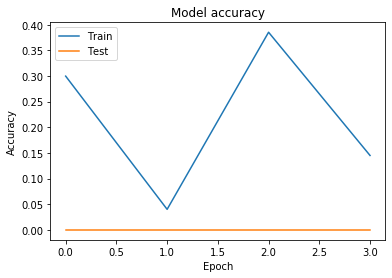

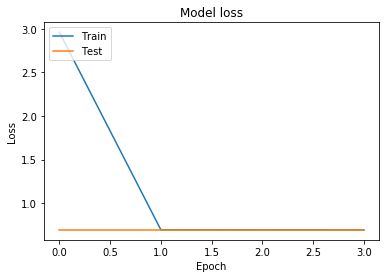

In [11]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Lets look at the out of the layers 

In [12]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

In [13]:
import os
train_cat_dir = 'data/training_set/cats'
train_dog_dir = 'data/training_set/dogs'
train_cat_names = list(os.listdir(train_cat_dir))
train_dog_names = list(os.listdir(train_dog_dir))

In [14]:
# Let's prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cat_dir, f) for f in train_cat_names]
dog_img_files = [os.path.join(train_dog_dir, f) for f in train_dog_names]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(image_height, image_width))  # this is a PIL image
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

In [15]:
# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

C:\Users\Ajays\.conda\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


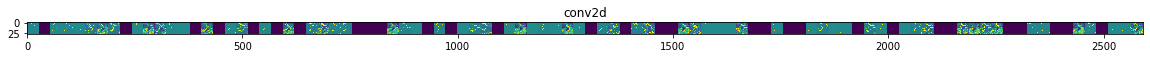

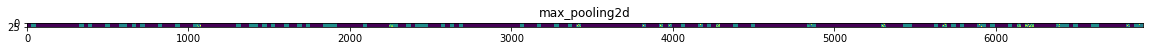

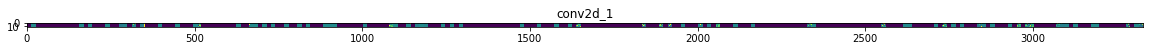

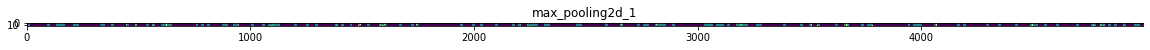

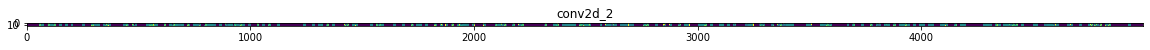

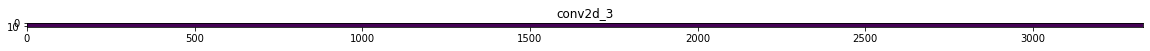

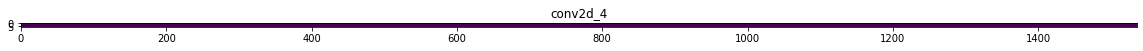

In [16]:
# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Lets look at what our model is predicting

array([[0.49988055, 0.50011945]], dtype=float32)

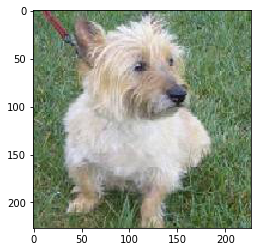

In [17]:
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(image_height, image_width))  # this is a PIL image
plt.imshow(img)
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
model.predict(x)

array([[0.49988055, 0.50011945]], dtype=float32)

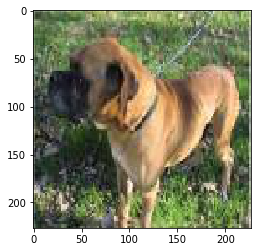

In [18]:
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(image_height, image_width))  # this is a PIL image
plt.imshow(img)
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
model.predict(x)

array([[0.49988055, 0.50011945]], dtype=float32)

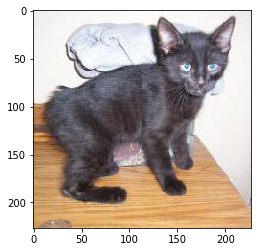

In [22]:
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(image_height, image_width))  # this is a PIL image
plt.imshow(img)
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
model.predict(x)

## Conclusion !
The model is too complex for this simple problem, you can achieve > 80% acc with just a simple 4 Convolutional layer network. 
The problem noticed in this case is vanishing gradients, the model simply guesses 50/50 everytime. To work around this and train the model to learn complex features from the image one can use the pre-trained weights that have been trained on a much larger dataset (done in another notebook) and tune that for the specific problem. 